In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("darkgrid")
sns.set_context("notebook")

In [4]:
file_name = "data/baltic_hydrography/INSPIRE_1979_2016_annual_oce_surf_and_bottom_hydrograhy.nc"

ds = xr.open_dataset(file_name)

ds = ds.sel(lon=slice(9, 31))

display(ds)

<xarray.Dataset>
Dimensions:  (lat: 538, lon: 475, time: 38)
Coordinates:
  * lon      (lon) float32 9.0225 9.0675 9.1125 9.1575 9.2025 9.2475 9.2925 ...
  * lat      (lat) float32 53.8225 53.845 53.8675 53.89 53.9125 53.935 ...
  * time     (time) datetime64[ns] 1979-12-31 1980-12-31 1981-12-31 ...
Data variables:
    BTEMP    (time, lat, lon) float32 ...
    SSS      (time, lat, lon) float32 ...
    BSALT    (time, lat, lon) float32 ...
    SST      (time, lat, lon) float32 ...
Attributes:
    history:  Created from monthly INSPIRE fields weighting all months equally.

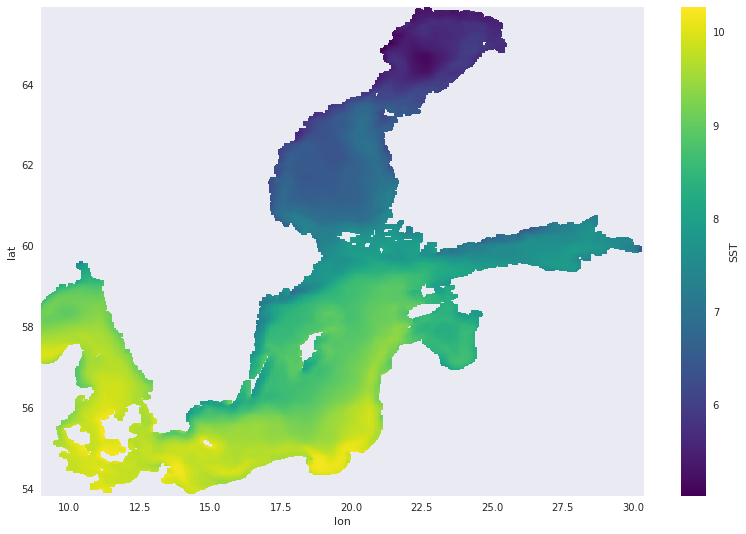

In [5]:
ds.SST.mean("time").plot(size=9);

In [6]:
def _weighted_horizontal_mean(da):
    lat = da.coords["lat"]
    cos_lat = xr.ufuncs.cos(xr.ufuncs.deg2rad(lat))
    cos_lat = cos_lat + da * 0
    weighted_mean = (cos_lat  * da).sum(dim=["lat", "lon"]) / cos_lat.sum(dim=["lat", "lon"])
    weighted_mean = weighted_mean.rename(da.name)
    return weighted_mean 

def _get_time_in_seconds(time):
    if time.ndim != 0:
        time = (time - time[0]).data
    time = time.astype("timedelta64[s]").astype("float")
    return time

def _get_trend(da):
    time = _get_time_in_seconds(da.coords["time"])
    one_decade = _get_time_in_seconds(np.timedelta64(10, "Y"))
    time /= one_decade
    z = np.polyfit(time, da.data, 1)
    da_trend = 0 * da + np.polyval(z, time)
    slope = z[0] * time[1]
    total_diff = z[0] * time[-1]
    return da_trend, slope, total_diff

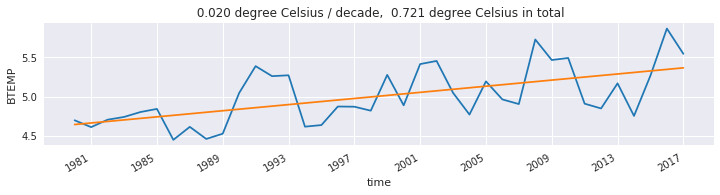

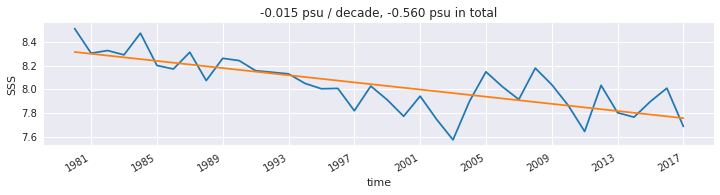

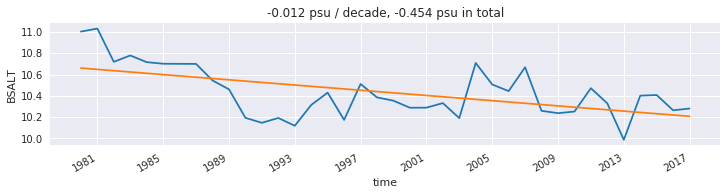

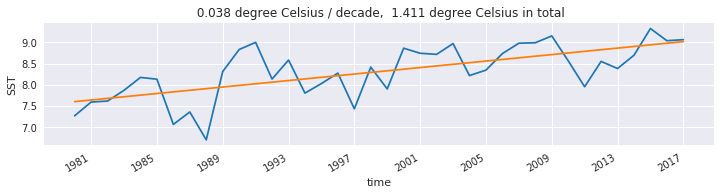

In [7]:
for v in [ds[v] for v in ds.variables 
          if "time" in ds[v].coords and "lat" in ds[v].coords]:
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 2.5))
    
    v_mean = _weighted_horizontal_mean(v)
    v_mean.plot(ax=ax);
    
    v_trend, slope, total_diff = _get_trend(v_mean)
    v_trend.plot(ax=ax);
    
    ax.set_title(("{slope: .3f} {units} / decade, " +
                  "{total: .3f} {units} in total"
                 ).format(slope=slope, total=total_diff, units=v.units));

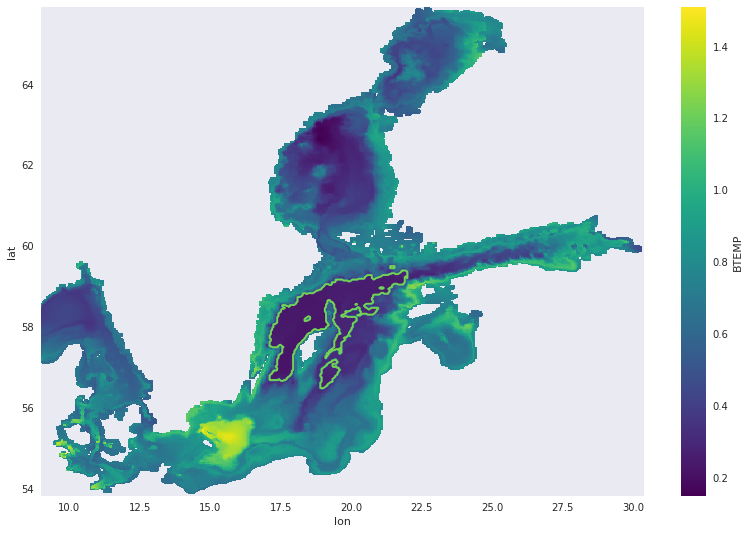

In [8]:
ds["deep_gotland"] = (
    (ds.BTEMP.std("time") < 0.3) &
    (ds.coords["lat"] < 59.5) & (ds.coords["lon"] < 22.0))
ds.deep_gotland.rename("deep Gotland basin waters")
ds.BTEMP.std("time").plot(size=9);
ds.deep_gotland.plot.contour();

In [9]:
ds["BTEMP_dg"] = ds.BTEMP.where(ds.deep_gotland).rename(ds.BTEMP.name + "_DG")
ds["BSALT_dg"] = ds.BSALT.where(ds.deep_gotland).rename(ds.BSALT.name + "_DG")

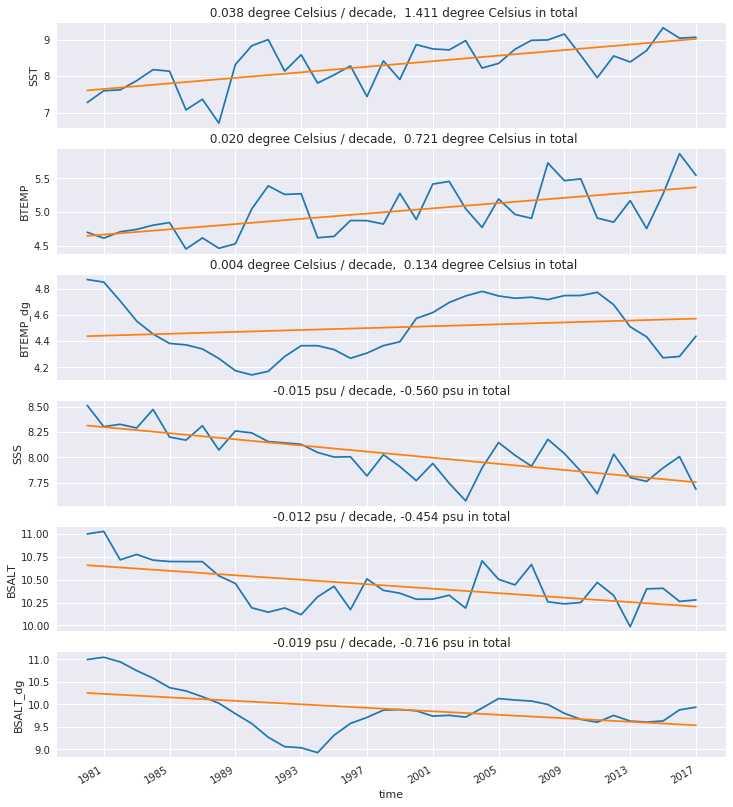

In [10]:
fig, ax_vec = plt.subplots(6, 1, sharex=True, figsize=(12, 15))
isub = 0

for ax, v in zip(ax_vec, [ds[vn] for vn in ["SST", "BTEMP", "BTEMP_dg",
                                           "SSS", "BSALT", "BSALT_dg"]]):

    v_mean = _weighted_horizontal_mean(v)
    v_mean.plot(ax=ax);

    v_trend, slope, total_diff = _get_trend(v_mean)
    v_trend.plot(ax=ax);
    
    ax.set_title(("{slope: .3f} {units} / decade, " +
                  "{total: .3f} {units} in total"
                 ).format(slope=slope, total=total_diff, units=v.units))